In [9]:
# HIDDEN
from datascience import *
%matplotlib inline

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
import pylab as pl
import math
from scipy import stats
from scipy import misc
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [1]:
# HIDDEN

# Functions from earlier in the chapter

# Correlation coefficient

def corr(table, column_A, column_B):
    x = table[column_A]
    y = table[column_B]
    x_su = (x-np.mean(x))/np.std(x)
    y_su = (y-np.mean(y))/np.std(y)
    return np.mean(x_su*y_su)

# Slope and intercept of regression line

def regress(table, column_x, column_y):
    r = corr(table, column_x, column_y)
    reg_slope = r*np.std(table[column_y])/np.std(table[column_x])
    reg_int = np.mean(table[column_y]) - reg_slope*np.mean(table[column_x])
    return np.array([reg_slope, reg_int])

# Fitted value at x

def fit(table, column_x, column_y, x):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*x + slope_int[1]

# Fitted values for all points in the scatter

def fitted_values(table, column_x, column_y):
    slope_int = regress(table, column_x, column_y)
    return slope_int[0]*table[column_x] + slope_int[1]

# Scatter plot with fitted (regression) line

def scatter_fit(table, column_x, column_y):
    t = table
    t['fit'] = fitted_values(table, column_x, column_y)
    ts = t.sort(column_x)
    plots.scatter(table[column_x], table[column_y], s=10)
    plots.plot(ts[column_x], ts['fit'], lw=1, color='green')
    plots.xlabel(column_x)
    plots.ylabel(column_y)

## Correlated Predictors

Correlations between predictor variables are important factors in selecting the set of predictors to use in a regression model. Here is an example that demonstrates some of the considerations that are involved in variable selection.

The data consist of measurements on the eggs of a species of small bird, as recorded by Abrahams and Rizzardi in the BLSS statistical system. The goal is to use dimensions of an egg to estimate the weight of the bird that hatches from the egg; as bigger hatchlings are more likely to survive, the estimates can be used to help predict the population size of the species.

The variables are:

- ``e_length``: the length of the egg, in millimeters
- ``e_breadth``: the width of the egg at its widest part, in millimeters
- ``e_weight``: the weight of the egg, in grams
- ``b_weight``: the weight of the bird that hatched from the egg, in grams

In [4]:
birds = Table.read_table('birds.csv')
birds

e_length,e_breadth,e_weight,b_weight
28.8,21.84,7.4,5.2
29.04,22.45,7.7,5.4
29.36,22.48,7.9,5.6
30.1,21.71,7.5,5.3
30.17,22.75,8.3,5.9
30.34,22.84,8.5,5.8
30.36,22.5,8.2,5.8
30.46,22.72,8.3,6
30.54,23.31,9,6.1
30.62,22.94,8.5,6.2


In order to estimate ``b_weight`` based on a combination of the other variables, we will start by examining the correlation matrix. Not surprisingly, the variable most highly correlated with the weight of the bird is the weight of the egg, ``e_weight``. But the linear dimensions ``e_length`` and ``e_breadth`` are also quite highly correlated with ``b_weight``; also, all the dimensions of the egg are correlated with each other.

In [5]:
# HIDDEN

df_birds = pd.read_csv('birds.csv')
df_birds.corr()

,e_length,e_breadth,e_weight,b_weight
e_length,1.000000,0.402764,0.792449,0.676142
e_breadth,0.402764,1.000000,0.839077,0.733687
e_weight,0.792449,0.839077,1.000000,0.847228
b_weight,0.676142,0.733687,0.847228,1.000000


The scatter plot of the weight of the bird and the weight of the egg is shown below, along with the regression line. Just based on the graph, it is reasonable to conclude that the fit is fairly good.

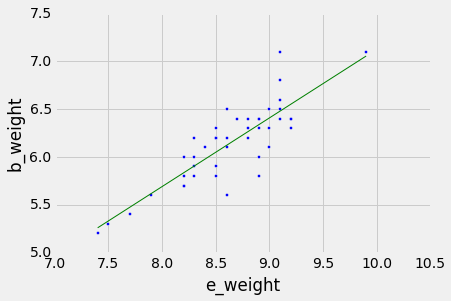

In [17]:
scatter_fit(birds, 'e_weight', 'b_weight')

The summary statistics confirm this assessment. For example $R^2$ is quite high: 0.718. The 95% confidence interval for the slope does not contain 0. All of this points to a genuine linear trend in the relation between the weight of the egg and the weight of the bird that hatches from the egg.

In [6]:
# HIDDEN

bird_x = df_birds[['e_weight']]
bird_x = sm.add_constant(bird_x)
bird_y = df_birds['b_weight']
est = sm.OLS(bird_y, bird_x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               b_weight   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     106.8
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           4.15e-13
Time:                        15:16:55   Log-Likelihood:                 5.0722
No. Observations:                  44   AIC:                            -6.144
Df Residuals:                      42   BIC:                            -2.576
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0583      0.601     -0.097      0.923        -1.271     1.155
e_weight       0.7185      0.070     10.336      0.000         0.578     0.859
==============================================================================
Omnibus:                        2.737   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.254   Jarque-Bera (JB):                1.986
Skew:                          -0.033   Prob(JB):                        0.370
Kurtosis:                       4.039   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is interesting to see what happens when we use all of the dimensions of the egg – length, breadth, and weight – as predictors. Compared to the simple regression based on egg weight alone, there is only a tiny increase in $R^2$: 0.724 compared to 0.718. Also, the adjusted $R^2$ goes down slightly, from 0.711 to 0.703. There is no substantial gain in throwing in the linear dimensions of the egg as predictors, compared to using just egg weight alone.

In [7]:
# HIDDEN

bird_x = df_birds[['e_weight', 'e_breadth', 'e_length']]
bird_x = sm.add_constant(bird_x)
bird_y = df_birds['b_weight']
est = sm.OLS(bird_y, bird_x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               b_weight   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     34.98
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           2.90e-11
Time:                        15:17:03   Log-Likelihood:                 5.5617
No. Observations:                  44   AIC:                            -3.123
Df Residuals:                      40   BIC:                             4.013
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -4.6057      4.843     -0.951      0.347       -14.394     5.183
e_weight       0.4312      0.317      1.360      0.181        -0.209     1.072
e_breadth      0.2159      0.229      0.944      0.351        -0.246     0.678
e_length       0.0666      0.083      0.803      0.426        -0.101     0.234
==============================================================================
Omnibus:                        3.670   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                3.399
Skew:                          -0.029   Prob(JB):                        0.183
Kurtosis:                       4.360   Cond. No.                     5.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###Collinearity

That too many predictor variables have been used in this regression is most apparent when you look at the confidence intervals for the slopes. All of the intervals contain 0, so it appears that there could be no linear trend in the relation between the response variable and the predictors. Yet $R^2$ is high. How can we reconcile these two apparently contradictory observations?

The answer lies in the correlation matrix. It shows that the three predictor variables are all correlated with each other. This is called *collinearity*. Because of collinearity, none of the slopes has a clear practical interpretation: it is not possible to increase one of the predictor variables while holding the others constant.

Therefore this regression gives little indication of how each individual predictor variable affects the estimate of the response. The small increase in $R^2$ has been obtained at a steep price: the interpretability of the model. 

The problem of collinearity can be mitigated by choosing the predictors more carefully. The correlation matrix shows that egg weight is highly correlated with both egg length and egg breadth. However, the correlation between egg length and egg breadth is much smaller. So it is a reasonable to regress bird weight on just the two linear dimensions of the egg.

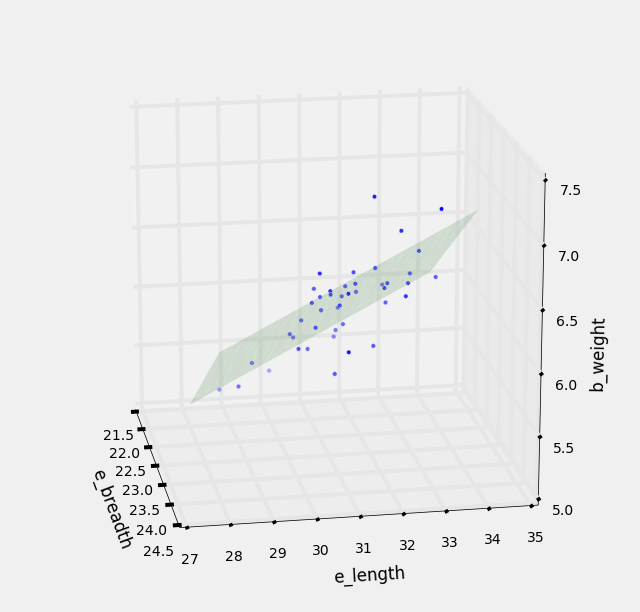

In [15]:
# HIDDEN

fig = plots.figure(figsize=(10,10))
ax = plots.axes(projection='3d')
ax.scatter(birds['e_breadth'], birds['e_length'], birds['b_weight'], zdir='z')
x = np.arange(22,24,0.01)
y = np.arange(28,34,0.01)
x,y = np.meshgrid(x,y)
z = 0.5057*x + 0.1695*y - 10.7386
ax.plot_surface(x,y,z,alpha=0.15,color='g')
ax.view_init(elev=18,azim=350)
ax.set_xlabel('e_breadth')
ax.set_ylabel('e_length')
ax.set_zlabel('b_weight')
None

In [11]:
# HIDDEN

bird_x = df_birds[['e_breadth', 'e_length']]
bird_x = sm.add_constant(bird_x)
bird_y = df_birds['b_weight']
est = sm.OLS(bird_y, bird_x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               b_weight   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     50.49
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           8.73e-12
Time:                        15:17:34   Log-Likelihood:                 4.5668
No. Observations:                  44   AIC:                            -3.134
Df Residuals:                      41   BIC:                             2.219
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -10.7386      1.788     -6.007      0.000       -14.349    -7.128
e_breadth      0.5057      0.084      6.006      0.000         0.336     0.676
e_length       0.1695      0.034      4.955      0.000         0.100     0.239
==============================================================================
Omnibus:                        4.685   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                5.379
Skew:                           0.016   Prob(JB):                       0.0679
Kurtosis:                       4.713   Cond. No.                     2.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This regression can be much more clearly interpreted than the regression based on all three predictors. The value of $R^2$ is just over 0.7, and the confidence intervals for the two slopes don't contain 0. Because of the relative lack of collinearity between the two predictors, each slope has meaning.

Indeed, the regression based on the two linear dimensions of the egg is quite comparable to the simple regression based on egg weight. To see why, let us examine the relation between egg weight and the two linear dimensions. How can we do this?

A good way is to use the technique that we have been using all through this section: multiple regression. Let's see what happens when we try to estimate egg weight based on egg length and egg breadth.

In [12]:
# HIDDEN

bird_x = df_birds[['e_breadth', 'e_length']]
bird_x = sm.add_constant(bird_x)
bird_y = df_birds['e_weight']
est = sm.OLS(bird_y, bird_x).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               e_weight   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     394.6
Date:                Sat, 05 Dec 2015   Prob (F-statistic):           1.65e-27
Time:                        15:17:41   Log-Likelihood:                 36.169
No. Observations:                  44   AIC:                            -66.34
Df Residuals:                      41   BIC:                            -60.98
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -14.2220      0.872    -16.314      0.000       -15.983   -12.461
e_breadth      0.6719      0.041     16.367      0.000         0.589     0.755
e_length       0.2386      0.017     14.308      0.000         0.205     0.272
==============================================================================
Omnibus:                        1.287   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.526   Jarque-Bera (JB):                0.605
Skew:                           0.250   Prob(JB):                        0.739
Kurtosis:                       3.281   Cond. No.                     2.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notice the extremely high value of $R^2$. This indicates that egg weight is very close to a linear function of egg length and egg breadth. Therefore, the information in egg weight as a predictor of bird weight is essentially the same as the information in a linear function of egg length and breadth. For confirmation, here is the scatter plot of the three variables. As you can see, the points are closely clustered about a plane.

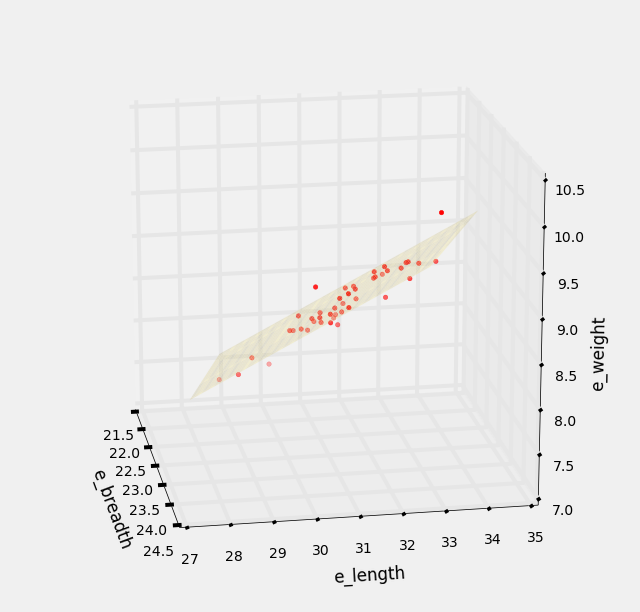

In [14]:
# HIDDEN 

fig = plots.figure(figsize=(10,10))
ax = plots.axes(projection='3d')
ax.scatter(birds['e_breadth'], birds['e_length'], birds['e_weight'], zdir='z', color='r')
x = np.arange(22,24,0.01)
y = np.arange(28,34,0.01)
x,y = np.meshgrid(x,y)
z = 0.6719*x + 0.2386*y - 14.222
ax.plot_surface(x,y,z,alpha=0.15,color='gold')
ax.view_init(elev=18,azim=350)
ax.set_xlabel('e_breadth')
ax.set_ylabel('e_length')
ax.set_zlabel('e_weight')
None